# Predict the sentiment of a tweet and the words supporting the sentiment

EL ATIFI Sofian and MIGNON Hadrien

# Data and packages

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import spacy
from spacy import displacy
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import string
import re

In [4]:
!nvidia-smi
!pip install -q -U watermark
!pip install -qq transformers
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

     |████████████████████████████████| 2.1MB 5.6MB/s 
     |████████████████████████████████| 901kB 18.7MB/s 
     |████████████████████████████████| 3.3MB 29.1MB/s 
Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.8.1+cu101
transformers: 4.5.1



In [5]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 43
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
!python -m spacy download en_core_web_sm

In [7]:
df = pd.read_csv("/content/drive/MyDrive/3A/ML for NLP/projet/train.csv")
# convert target strings to integers
df["sentiment_int"], uniques = pd.factorize(df["sentiment"])

# TASK1: Predict sentiment

In [ ]:
# Loading Spacy small model as nlp for tokenization tools
nlp = spacy.load("en_core_web_sm")

In [ ]:
# Spillting the train and test data
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

df_sample = df.sample(frac=0.1)
X = df_sample['text']
y = df_sample['sentiment_int']
X_train_pp, X_test_pp, y_train, y_test = train_test_split(X, y, test_size = 0.1,random_state=RANDOM_SEED)
df_train = pd.concat([X_train_pp, y_train], axis=1)
df_test = pd.concat([X_test_pp, y_test], axis=1)
df_val = df_test 
print(X_train_pp.shape, y_train.shape,X_test_pp.shape,y_test.shape)

(2473,) (2473,) (275,) (275,)


## Data exploration

L'étiquetage des sentiments semble un peu arbitraire, faut pas s'étonner si on fait pas des performances de folie...

In [ ]:
pd.set_option('display.max_colwidth', None)
df[["text","sentiment"]][20:40]

,text,sentiment
20,"oh Marly, I`m so sorry!! I hope you find her soon!! <3 <3",neutral
21,Playing Ghost Online is really interesting. The new updates are Kirin pet and Metamorph for third job. Can`t wait to have a dragon pet,positive
22,is cleaning the house for her family who is comming later today..,neutral
23,gotta restart my computer .. I thought Win7 was supposed to put an end to the constant rebootiness,neutral
24,SEe waT I Mean bOuT FoLL0w fRiiDaYs... It`S cALLed LoSe f0LloWeRs FridAy... smH,neutral
25,"the free fillin` app on my ipod is fun, im addicted",positive
26,I`m sorry.,negative
27,On the way to Malaysia...no internet access to Twit,negative
28,juss came backk from Berkeleyy ; omg its madd fun out there havent been out there in a minute . whassqoodd ?,positive
29,Went to sleep and there is a power cut in Noida Power back up not working too,negative


In [ ]:
df.sentiment.value_counts()

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64

Sci kit learn a besoin de labels de type "integer" pour faire de la classification.

## Preprocessing of bags of word embeddings


In [ ]:
punctuation  = "!#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
!pip install emot
import re
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
EMOTICONS["<3"]= "Heartemo"

# Converting emojis to words
def convert_emojis(text):
    for emot in UNICODE_EMO:
        text = text.replace(emot, "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()))
        return text

#Converting emoticons to words    
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
    return text

to_replace=[re.escape(i) for i in punctuation]
replace_with=[' '+i+' ' for i in punctuation]

def put_space_before_after_punctuation(x):
    x=x.lower()
    x=pd.DataFrame([x])[0].replace(to_replace,replace_with,regex=True)[0]
    return x

def preprocess_keep_emoticons_punctuation(s):
    s = convert_emojis(s)
    s = convert_emoticons(s)
    s = s.replace("_", "") 
    s = put_space_before_after_punctuation(s)

    doc = nlp(s) #creates a list of tokens (token = word)
    tokens = []
    for token in doc:
        if token.lemma_ != '-PRON-':
            temp = token.lemma_.lower().strip()
        else:
            temp = token.lower_
        tokens.append(temp)
    
    return tokens

#preprocess_keep_emoticons_punctuation(":) :(  !?toto! safer safest run runner running quick quicker cook") #en

In [ ]:
from tqdm.notebook import tqdm
import numpy as np

X_train = np.array([preprocess_keep_emoticons_punctuation(s) for s in tqdm(X_train_pp)], dtype=object)
X_test = np.array([preprocess_keep_emoticons_punctuation(s) for s in tqdm(X_test_pp)], dtype=object)


In [ ]:
print(X_train.shape, y_train.shape,X_test.shape,y_test.shape)

(2473,) (2473,) (275,) (275,)


#### Analyse du preprocessing


Nombre de mots uniques

In [ ]:
S = set()
for words in X:
  S.update(words)
print("Nombre de tweets=",len(X))
print("Nombre de mots=", len(S))

Nombre de tweets= 2748
Nombre de mots= 95


Nombre de tokens maximum dans une séquence ?

Si token = mots ?
si token = caractères ? meilleur approche si trop de fautes d'orthographes dans les tweets.

In [ ]:
S = set()
for words in X:
  for word in words:
    S.update(word)
print("Nombre de strings=", len(S))

Nombre de strings= 95


## Bags of word and SVM

## Modèle naïf

Classifieur majoritaire

In [ ]:
# If I always predict the class "neutral", I am successful in 40% of the 100 cases.
counts = df["sentiment_int"].value_counts()
print(counts)
print("accuracy of majority dummy classifier :", counts.max()/counts.sum())

0    11117
2     8582
1     7781
Name: sentiment_int, dtype: int64
accuracy of majority dummy classifier : 0.40454876273653567


In [ ]:
# Balancy accuracy is defined as the average of recall obtained on each class.
from sklearn.metrics import balanced_accuracy_score
y_pred_maj = pd.Series([0]*len(y_test))
print("Majority classifier \n")
print("Balanced accuracy:",round(balanced_accuracy_score(y_true=y_test, y_pred= y_pred_maj,  sample_weight=None, adjusted=False),4))
print("Confusion matrix:\n",
pd.DataFrame(confusion_matrix(y_test,y_pred_maj, normalize='true'), columns=uniques, index=uniques))

Majority classifier 

Balanced accuracy: 0.3333
Confusion matrix:
           neutral  negative  positive
neutral       1.0       0.0       0.0
negative      1.0       0.0       0.0
positive      1.0       0.0       0.0


## CountVectorizer (token occurrence matrix) + SVM

CountVectorize fait mieux que le tfidf pour la catégorie neutral mais il fait moins bien pour les catégories positifs et négatifs...

In [ ]:
# Creating the model and pipeline
from sklearn.feature_extraction.text import CountVectorizer
countVect = CountVectorizer(max_features=300, analyzer=lambda x:x)  # tokenisation is already done in preprocess_keep_emoticons_punctuation by nlp()
# max_feature builds a vocabulary that only consider the top max_features ordered by term frequency across the corpus.
svm = LinearSVC()
steps1 = [('countVect',countVect),('svm',svm)]
pipe = Pipeline(steps1)

In [ ]:
# Training the model
pipe.fit(X_train,y_train)
# Testing on the test dataset
y_pred_count = pipe.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
print("Simple counts vectorizer \n")
print("Balanced accuracy:",round(balanced_accuracy_score(y_true=y_test, y_pred= y_pred_count,  sample_weight=None, adjusted=False),6))
print("Confusion matrix:\n",
pd.DataFrame(confusion_matrix(y_test,y_pred_count, normalize='true'), columns=uniques, index=uniques))

Simple counts vectorizer 

Balanced accuracy: 0.58955
Confusion matrix:
            neutral  negative  positive
neutral   0.728814  0.127119  0.144068
negative  0.466667  0.466667  0.066667
positive  0.353659  0.073171  0.573171


## 1 gram Term Frequency-Inverse Document Frequency (TF-IDF)

In [ ]:
# Creating the model and pipeline
from sklearn.feature_extraction.text import CountVectorizer
cv_norm = TfidfVectorizer(max_features=300, analyzer=lambda x:x) 
svm = LinearSVC()
steps2 = [('cv',cv_norm),('svm',svm)]
pipe = Pipeline(steps2)

In [ ]:
# Training the model
pipe.fit(X_train,y_train)
# Testing on the test dataset
y_pred_count_normed = pipe.predict(X_test)

In [ ]:
print("Normalized counts vectorizer \n")
print("Balanced accuracy:",round(balanced_accuracy_score(y_true=y_test, y_pred= y_pred_count_normed,  sample_weight=None, adjusted=False),6))
print("Confusion matrix:\n",
pd.DataFrame(confusion_matrix(y_test,y_pred_count_normed, normalize='true'), columns=uniques, index=uniques))

Normalized counts vectorizer 

Balanced accuracy: 0.613392
Confusion matrix:
            neutral  negative  positive
neutral   0.720339  0.161017  0.118644
negative  0.386667  0.546667  0.066667
positive  0.329268  0.097561  0.573171


## 2 gram Term Frequency-Inverse Document Frequency (TF-IDF)

In [ ]:
# Creating the model and pipeline
from sklearn.feature_extraction.text import CountVectorizer
cv_norm2 = TfidfVectorizer(max_features=300, analyzer=lambda x:x, ngram_range=(1,2)) 
svm = LinearSVC()
steps3 = [('cv_norm2',cv_norm2),('svm',svm)]
pipe = Pipeline(steps3)

In [ ]:
# Training the model
pipe.fit(X_train,y_train)
# Testing on the test dataset
y_pred_count_normed2 = pipe.predict(X_test)

In [ ]:
print("Normalized counts vectorizer \n")
print("Balanced accuracy:",round(balanced_accuracy_score(y_true=y_test, y_pred= y_pred_count_normed2,  sample_weight=None, adjusted=False),6))
print("Confusion matrix:\n",
pd.DataFrame(confusion_matrix(y_test,y_pred_count_normed2, normalize='true'), columns=uniques, index=uniques))

Normalized counts vectorizer 

Balanced accuracy: 0.613392
Confusion matrix:
            neutral  negative  positive
neutral   0.720339  0.161017  0.118644
negative  0.386667  0.546667  0.066667
positive  0.329268  0.097561  0.573171


## BERT

In [ ]:
!nvidia-smi
!pip install -q -U watermark
!pip install -qq transformers
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

     |████████████████████████████████| 2.1MB 4.2MB/s 
     |████████████████████████████████| 901kB 38.9MB/s 
     |████████████████████████████████| 3.3MB 40.4MB/s 
Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.8.1+cu101
transformers: 4.5.1



In [ ]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Data Preprocessing

 Here are the specific preprocessings requirements for BERT: 

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*



We use a cased version of BERT and tokenizer since "BAD" might convey more sentiment than "bad" for exemple. 

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

Let's load a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

### Choosing Sequence Length

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [ ]:
token_lens = []

for txt in df.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


and plot the distribution:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


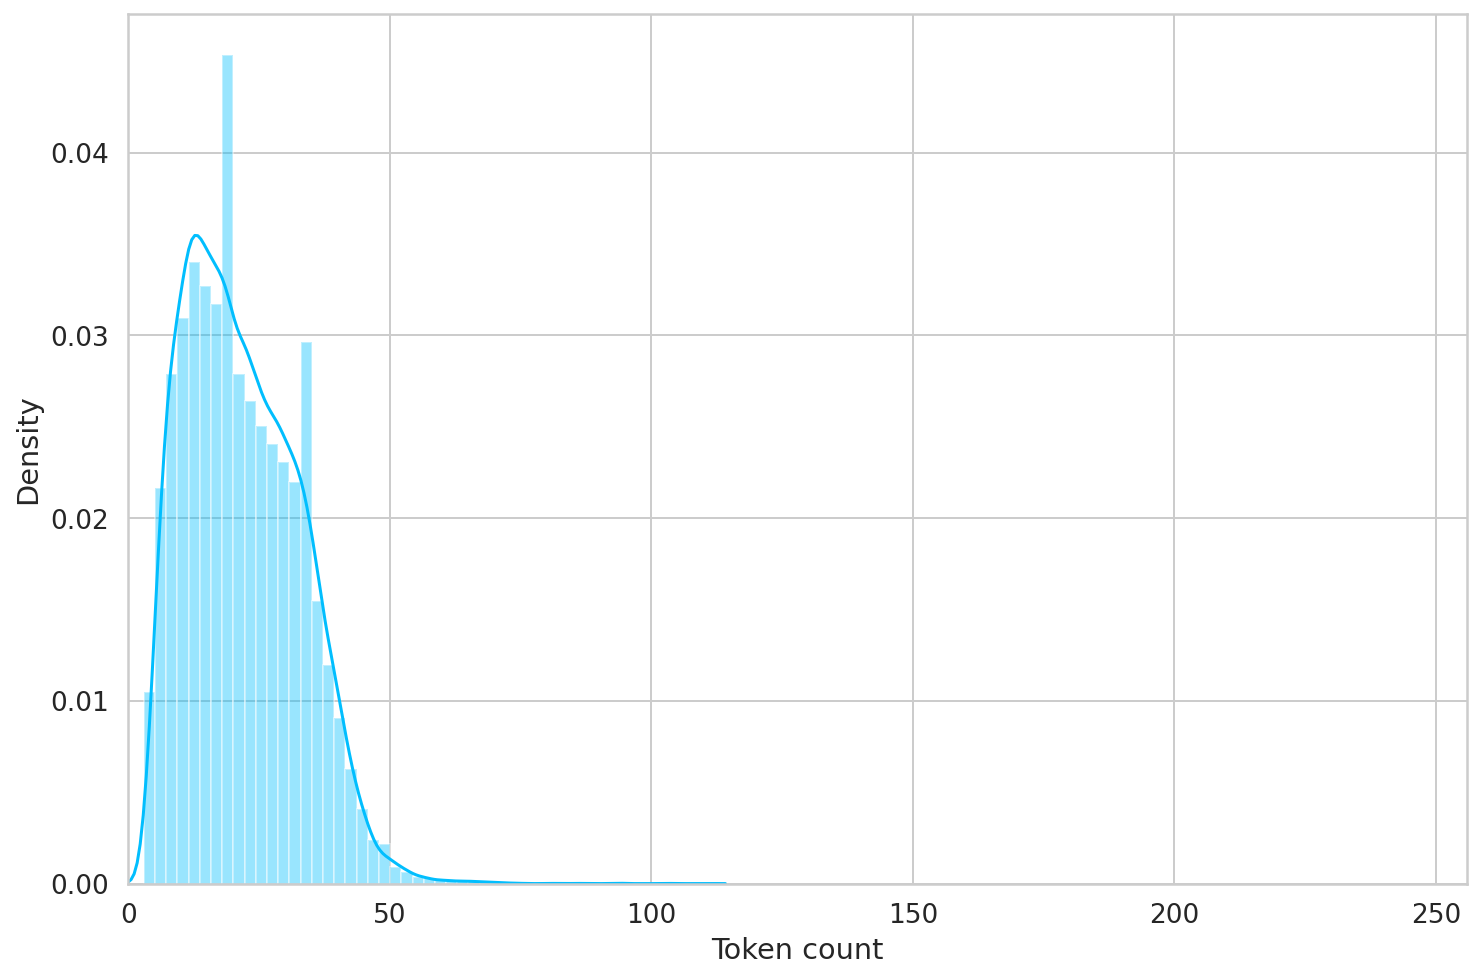

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the tweets contain less than 50 tokens, but we'll be on the safe side and choose a maximum length of 70.

In [ ]:
MAX_LEN = 70

We have all building blocks required to create a PyTorch dataset. Let's do it:

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. 

We also need to create a couple of data loaders. Here's a helper function to do it:

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text.to_numpy(),
    targets=df.sentiment_int.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

## Sentiment Classification with BERT and Hugging Face

There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task you might want to use [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) or something else. 

But who cares, right? We're *hardcore*! We'll use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our sentiment classifier on top of it. Let's load the model:

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)

And try to use it on the encoding of our sample text:

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes) #hidden_size = d = taille d'un word embedding en sortie du transformeur
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
      
    )
    output = self.drop(pooled_output)
    
    return self.out(output)

Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [ ]:
model = SentimentClassifier(n_classes=3)
model = model.to(device)

We'll move the example batch of our training data to the GPU:

In [ ]:
input_ids = data['input_ids'].to(device)
print(input_ids)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

tensor([[  101,  3046, 22232,  ...,     0,     0,     0],
        [  101, 15276,  6262,  ...,     0,     0,     0],
        [  101,  6243,  1128,  ...,     0,     0,     0],
        ...,
        [  101,   178,   169,  ...,     0,     0,     0],
        [  101,  1192,   169,  ...,     0,     0,     0],
        [  101,  8413,   131,  ...,     0,     0,     0]])
torch.Size([32, 70])
torch.Size([32, 70])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5263, 0.1911, 0.2826],
        [0.4109, 0.1274, 0.4616],
        [0.4837, 0.1235, 0.3927],
        [0.4982, 0.0770, 0.4248],
        [0.4655, 0.1559, 0.3786],
        [0.3695, 0.1659, 0.4646],
        [0.4193, 0.1595, 0.4212],
        [0.4136, 0.1722, 0.4142],
        [0.4338, 0.0906, 0.4756],
        [0.4476, 0.1203, 0.4321],
        [0.4460, 0.1588, 0.3953],
        [0.3482, 0.1477, 0.5041],
        [0.5575, 0.1097, 0.3328],
        [0.2929, 0.2213, 0.4857],
        [0.3971, 0.0852, 0.5177],
        [0.6269, 0.1048, 0.2683],
        [0.3848, 0.2081, 0.4072],
        [0.5470, 0.0842, 0.3688],
        [0.4078, 0.1500, 0.4422],
        [0.5088, 0.1405, 0.3507],
        [0.4033, 0.1671, 0.4296],
        [0.4273, 0.1949, 0.3778],
        [0.4252, 0.1878, 0.3870],
        [0.5867, 0.1200, 0.2933],
        [0.4424, 0.2081, 0.3494],
        [0.4196, 0.1342, 0.4462],
        [0.4332, 0.0782, 0.4887],
        [0.5444, 0.1029, 0.3527],
        [0.4136, 0.1470, 0.4394],
        [0.413

### Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [ ]:
EPOCHS = 3

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

Let's continue with writing a helper function for training our model for one epoch:

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

Let's write another one that helps us evaluate the model on a given data loader:

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We'll also store the training history:

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

Train loss 0.8251218864550958 accuracy 0.6215123331985443


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.6532224482960172 accuracy 0.7272727272727273

Epoch 2/3
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.44009998870583683 accuracy 0.8362312980186009


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.6645243598355187 accuracy 0.7527272727272727

Epoch 3/3
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.2501697385062774 accuracy 0.9203396684189243


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.7460728784402212 accuracy 0.76

CPU times: user 1h 22min 54s, sys: 2min 26s, total: 1h 25min 21s
Wall time: 1h 25min 8s


Note that we're storing the state of the best model, indicated by the highest validation accuracy.

Whoo, this took some time! We can look at the training vs validation accuracy:

(-1.0, 3.0)

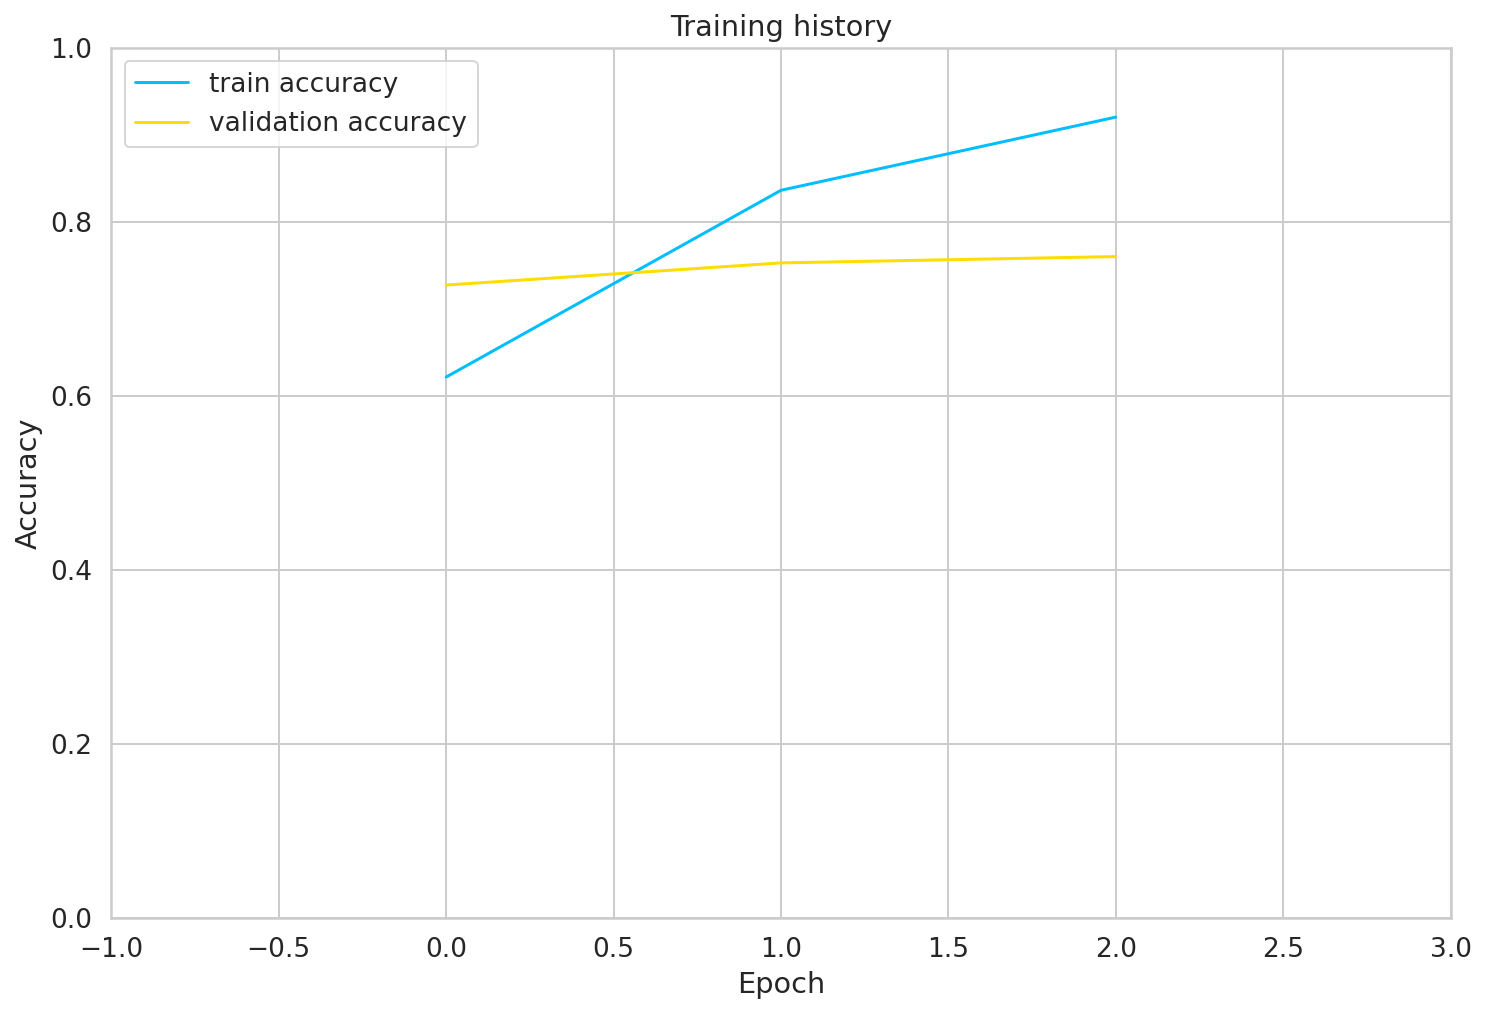

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.xlim([-1, 3])

The training accuracy starts to approach 100% after 10 epochs or so. You might try to fine-tune the parameters a bit more, but this will be good enough for us.

Don't want to wait? Uncomment the next cell to download my pre-trained model:

In [ ]:
# !gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA

# model = SentimentClassifier(len(class_names))
# model.load_state_dict(torch.load('best_model_state.bin'))
# model = model.to(device)

## Evaluation

So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

The accuracy is about 1% lower on the test set. Our model seems to generalize well.

We'll define a helper function to get the predictions from our model:

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [ ]:
y_review_texts, y_pred_bert, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

In [ ]:
print(y_test.shape, y_pred_bert.shape)

torch.Size([275]) torch.Size([275])


In [ ]:
# Balance accuracy is defined as the average of recall obtained on each class.
from sklearn.metrics import balanced_accuracy_score
print("BERT \n")
print("Balanced accuracy:", balanced_accuracy_score(y_true=y_test, y_pred= y_pred_bert,  sample_weight=None, adjusted=False)
      )
print("Confusion matrix:\n",
pd.DataFrame(confusion_matrix(y_test,y_pred_bert, normalize='true'), columns=uniques, index=uniques))

BERT 

Balanced accuracy: 0.7486454457764916
Confusion matrix:
            neutral  negative  positive
neutral   0.822034  0.067797  0.110169
negative  0.266667  0.680000  0.053333
positive  0.207317  0.048780  0.743902


Let's have a look at the classification report

## Performance evaluation

### Quantitative evaluation

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

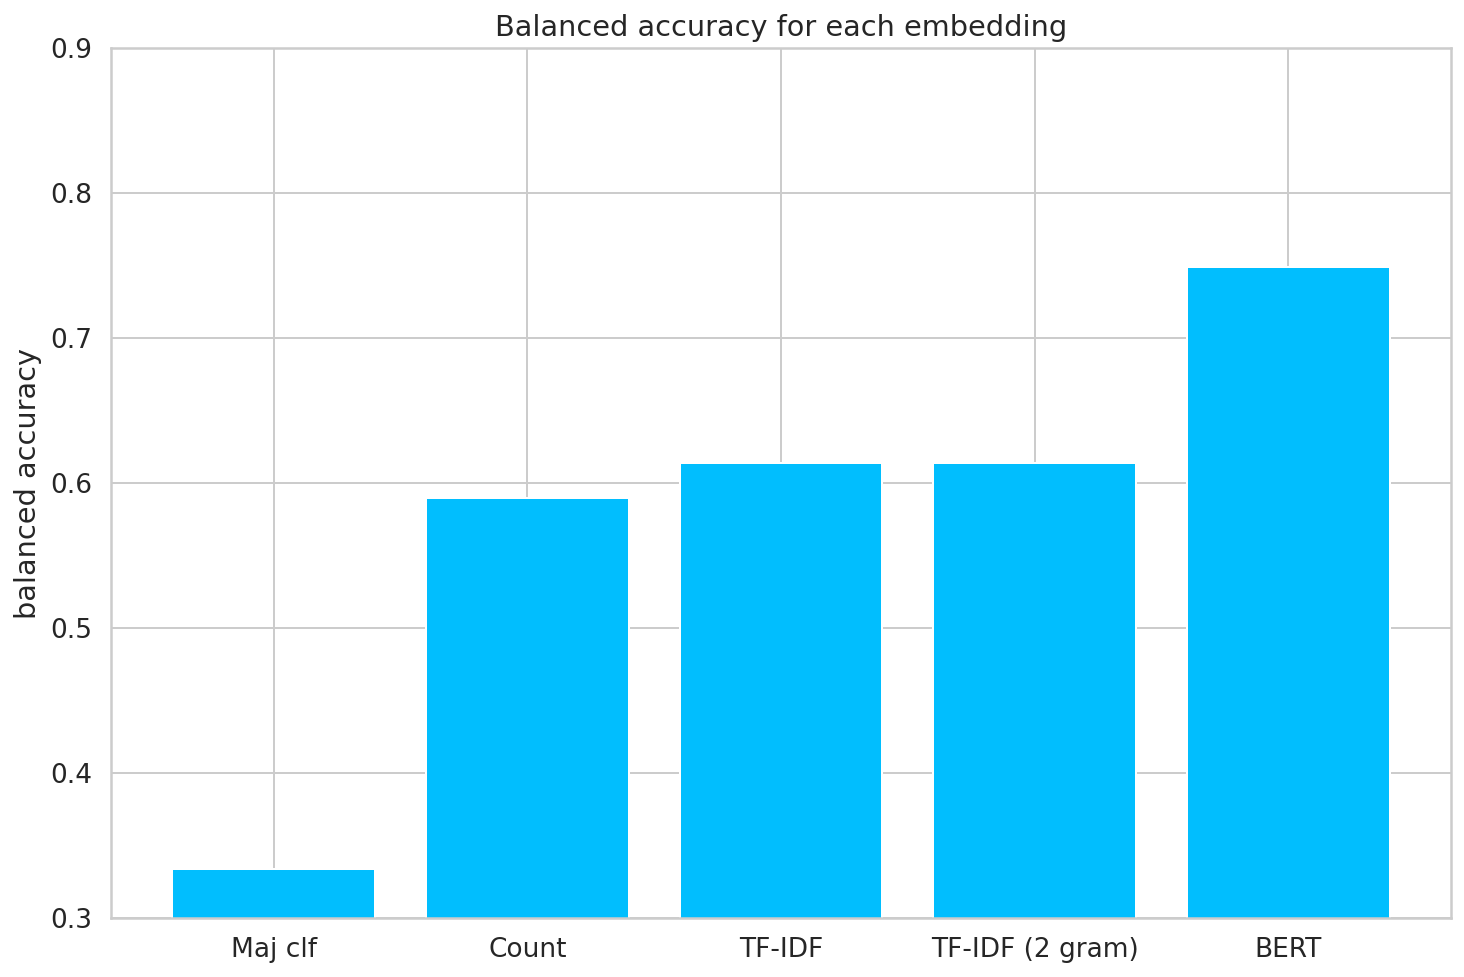

In [ ]:
import matplotlib.pyplot as plt
x = ["Maj clf","Count","TF-IDF","TF-IDF (2 gram)" , "BERT"]
height = [balanced_accuracy_score(y_true=y_test, y_pred= y_pred_maj,            sample_weight=None, adjusted=False),
          balanced_accuracy_score(y_true=y_test, y_pred= y_pred_count,          sample_weight=None, adjusted=False),
          balanced_accuracy_score(y_true=y_test, y_pred= y_pred_count_normed,   sample_weight=None, adjusted=False),
          balanced_accuracy_score(y_true=y_test, y_pred= y_pred_count_normed2,  sample_weight=None, adjusted=False),
          balanced_accuracy_score(y_true=y_test, y_pred= y_pred_bert,           sample_weight=None, adjusted=False)]

plt.bar(x,height)
plt.ylabel('balanced accuracy')
plt.title('Balanced accuracy for each embedding')
plt.ylim(bottom = 0.3, top = 0.9)
from google.colab import files
plt.savefig("/content/drive/MyDrive/3A/ML for NLP/projet/balAcc.png")
files.download("/content/drive/MyDrive/3A/ML for NLP/projet/balAcc.png") 
plt.show()

We compare the recall for each sentiment between Bert and Count

In [ ]:
from sklearn.metrics import classification_report

dictCount = classification_report(y_test, y_pred_count, target_names=uniques, output_dict = True)
dictBert = classification_report(y_test, y_pred_bert, target_names=uniques, output_dict = True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

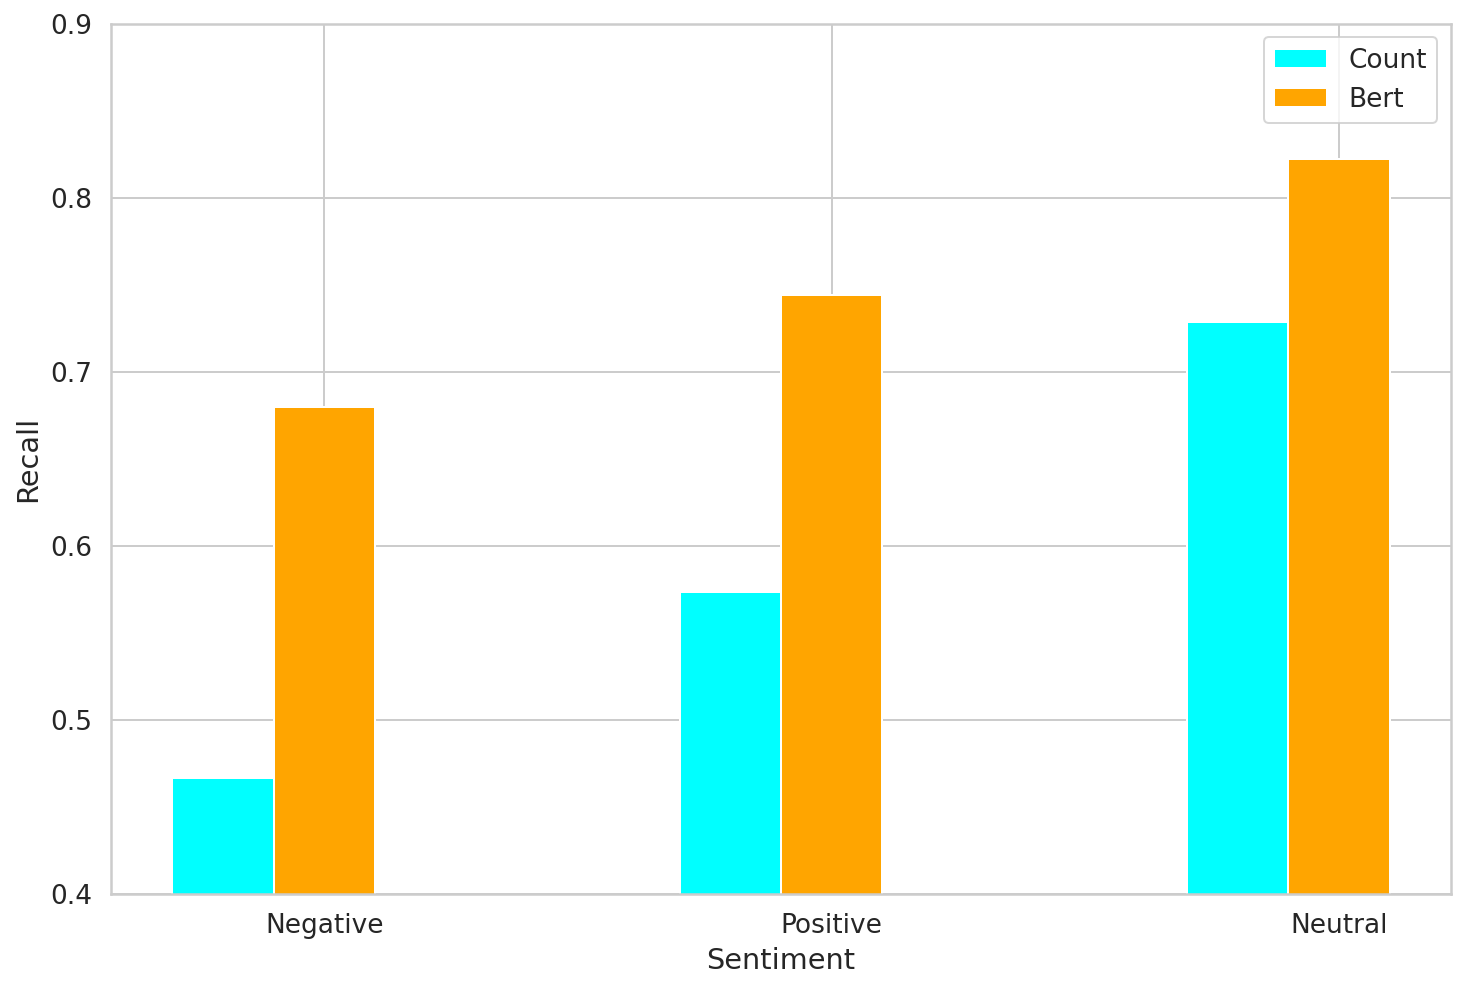

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
  
# create data
x = np.arange(3)
RecallCount = [dictCount['negative']['recall'],dictCount['positive']['recall'],dictCount['neutral']['recall']]
RecallBert = [dictBert['negative']['recall'],dictBert['positive']['recall'],dictBert['neutral']['recall']]
width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, RecallCount, width, color='cyan')
plt.bar(x, RecallBert, width, color='orange')
plt.xticks(x, ["Negative", "Positive", "Neutral"])
plt.xlabel("Sentiment")
plt.ylabel("Recall")
plt.legend(["Count", "Bert"])
plt.ylim(bottom = 0.4, top = 0.9)
from google.colab import files
plt.savefig("/content/drive/MyDrive/3A/ML for NLP/projet/RecallBertCount.png")
files.download("/content/drive/MyDrive/3A/ML for NLP/projet/RecallBertCount.png") 
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

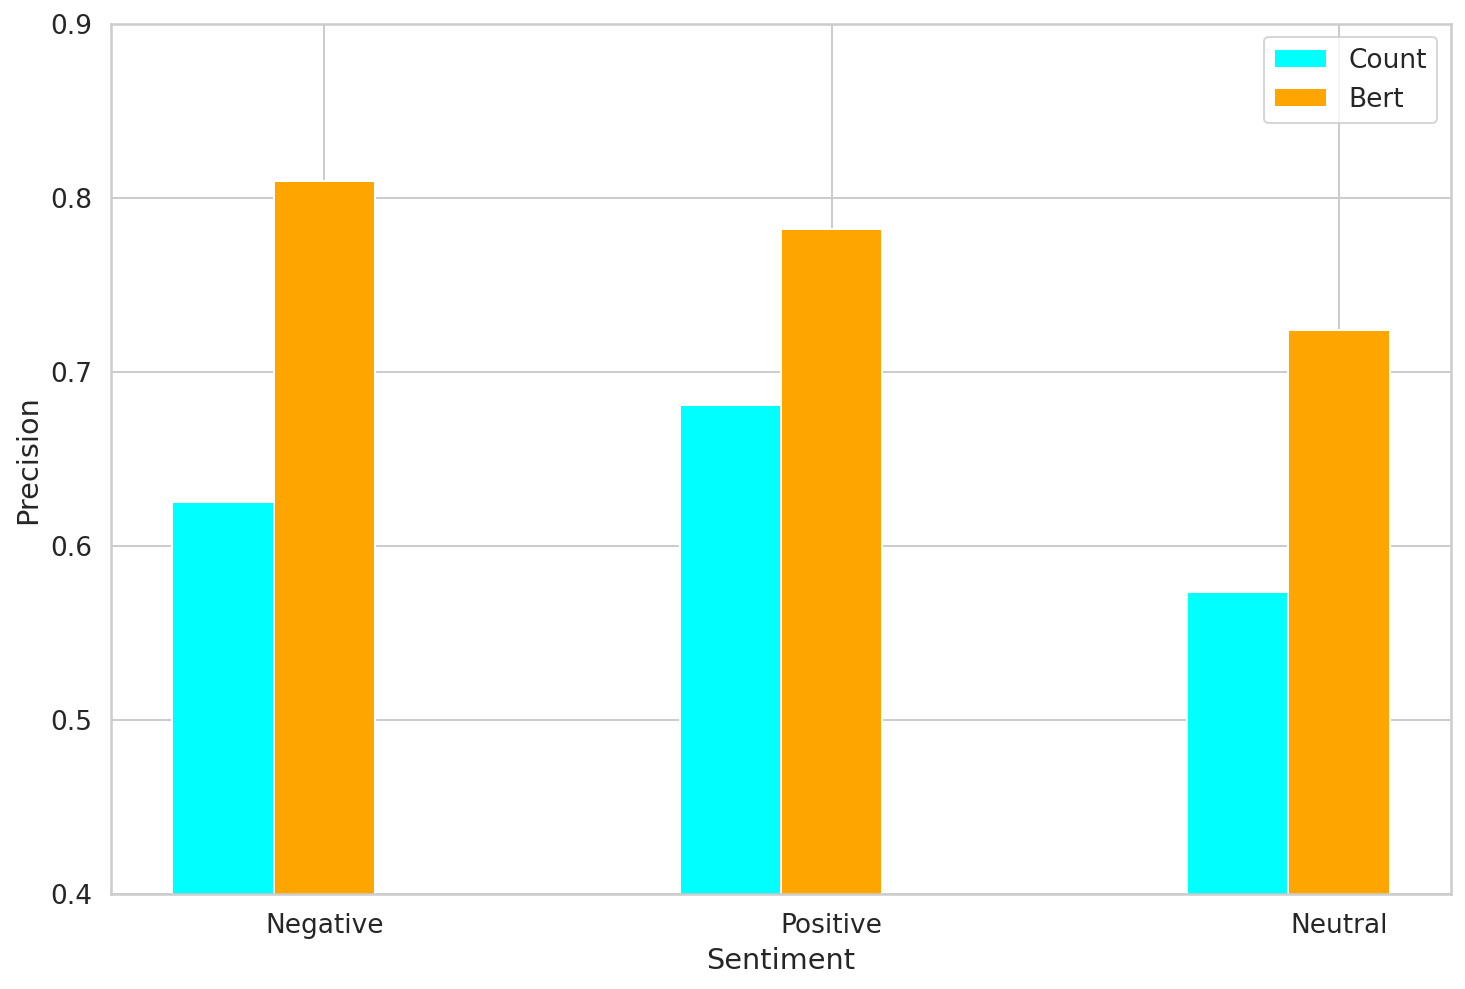

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
  
# create data
x = np.arange(3)
RecallCount = [dictCount['negative']['precision'],dictCount['positive']['precision'],dictCount['neutral']['precision']]
RecallBert = [dictBert['negative']['precision'],dictBert['positive']['precision'],dictBert['neutral']['precision']]
width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, RecallCount, width, color='cyan')
plt.bar(x, RecallBert, width, color='orange')
plt.xticks(x, ["Negative", "Positive", "Neutral"])
plt.xlabel("Sentiment")
plt.ylabel("Precision")
plt.legend(["Count", "Bert"])
plt.ylim(bottom = 0.4, top = 0.9)
from google.colab import files
plt.savefig("/content/drive/MyDrive/3A/ML for NLP/projet/RecallBertCount.png")
files.download("/content/drive/MyDrive/3A/ML for NLP/projet/RecallBertCount.png") 
plt.show()

### Qualitative evaluation

In [ ]:
print(type(pd.Series(y_test)),type(y_pred_count), type(y_pred_bert))
df_eval = pd.concat([X_test_pp.reset_index(drop = True), pd.Series(y_test), pd.Series(y_pred_bert), pd.Series(y_pred_count)], axis = 1)
df_eval.columns = ["tweet", "y_test","y_pred_bert","y_pred_count"]
type(df_eval)

<class 'pandas.core.series.Series'> <class 'numpy.ndarray'> <class 'torch.Tensor'>


pandas.core.frame.DataFrame

In [ ]:
pd.set_option('display.max_colwidth', None)
df_eval[df_eval.y_test == 1][df_eval.y_pred_bert == 1][df_eval.y_pred_count != 1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,tweet,y_test,y_pred_bert,y_pred_count
3,On the bus goin 2 work but omg seriously im sooooo tired dont know if i`ll survive the 8 hour shift,1,1,0
6,It`s tough being a thick chik,1,1,0
16,"no, def rubbish tonight",1,1,0
25,At work... supposed to be a day off but too much work to get done for PLM World... sigh,1,1,0
35,@__SANDY i dont know! they sent out emails using my account about random stuff i didnt even understand i changed all my passwords,1,1,0
44,Plans were taking flight to go out tonight but they`re now sinking in the Hudson since I have to work in he morning. Stupid bird strike.,1,1,0
47,my deep fry drumsticks were not as good as i thought they would be,1,1,2
51,I`ve experienced apathy over empathy in customer service situations too many times recently.,1,1,0
87,My throat is killing me,1,1,0
154,lol i wos gona send mine in bt i was too late ****,1,1,0


# TASK 2: Predict support words

In [10]:
df.apply(lambda row: row["selected_text"] in row["text"], axis = 1).mean()

1.0

In [192]:
# Spillting the train and test data
RANDOM_SEED = 43
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

df_sample = df.sample(frac=0.015)
df_train, df_test = train_test_split(df_sample[["text","selected_text","sentiment_int"]], test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
print(df_train.shape, df_test.shape, df_val.shape)

(370, 3) (21, 3) (21, 3)


## Data Preprocessing




We use a cased version of BERT and tokenizer since "BAD" might convey more sentiment than "bad" for exemple. 

In [12]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

Let's load a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [13]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

### Choosing Sequence Length

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [14]:
token_lens = []
for tweet in df.text: 
  tokens = tokenizer.encode(tweet, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


and plot the distribution:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


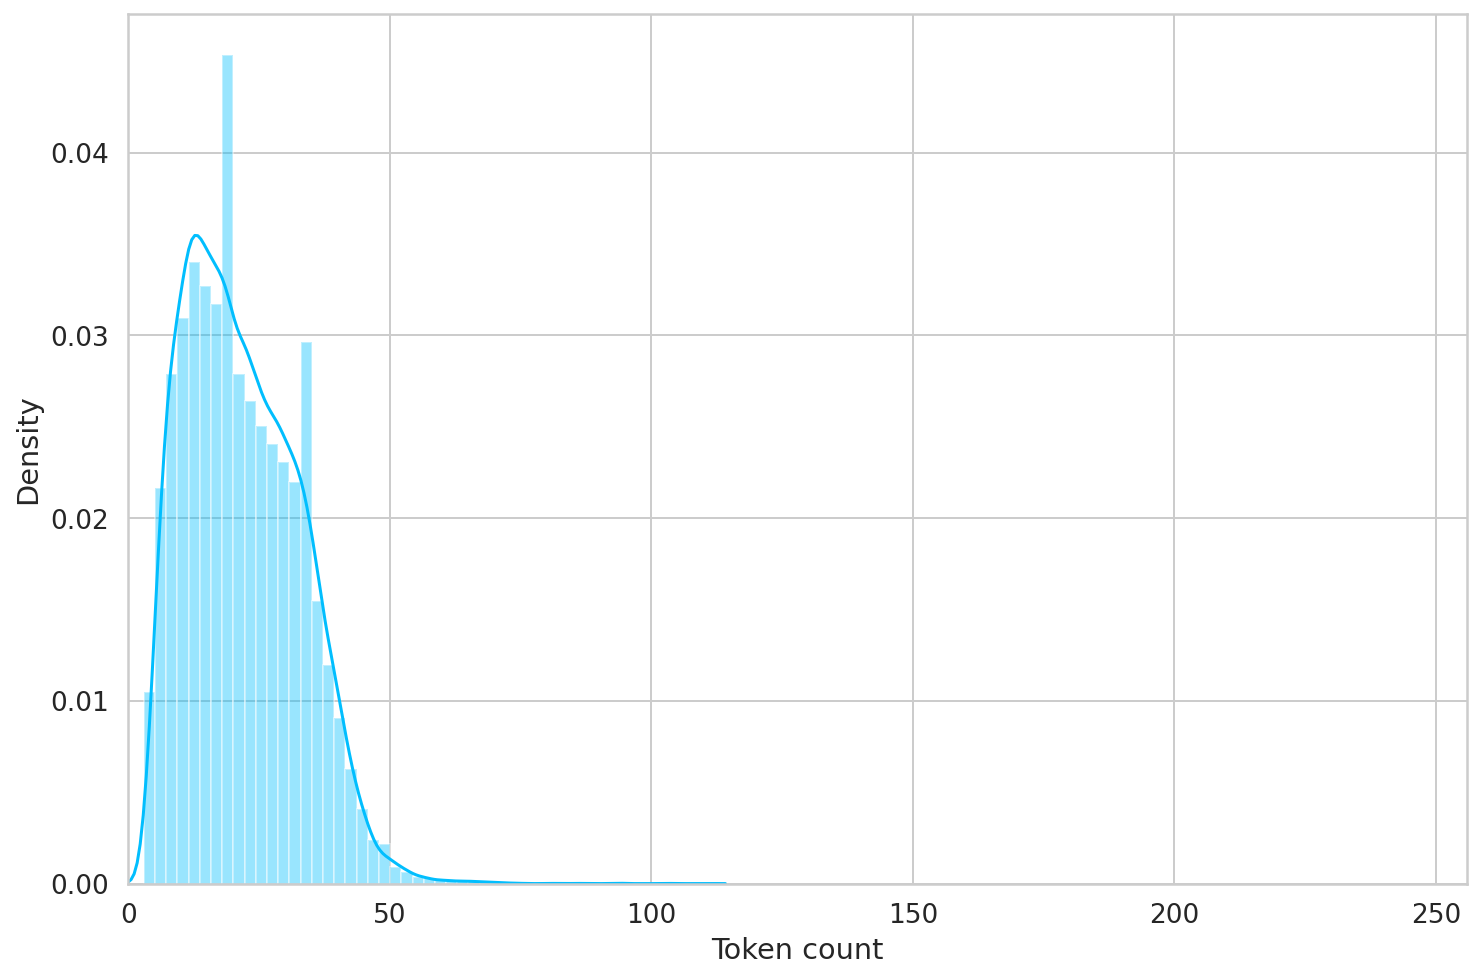

In [15]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the tweets contain less than 50 tokens, but we'll be on the safe side and choose a maximum length of 70.

In [147]:
MAX_LEN = 70

### DataSet config and boolean target vector 

*We* add a specific target vector for the supporting words prediction task (task 2)

In [17]:
def is_search_b_in_a_possible(b,a): #to remove tweets with anormal target suchas as: tweet= "i am kind", word support = "kind and gentle"
    assert len(b) <= len(a) 
    l = [(i, i+len(b)-1) for i in range(len(a)) if a[i:i+len(b)] == b]
    if l==[]:
      return False
    else:
      return True

def search_b_in_a(b,a): #we assume that b is always included in a
    assert len(b) <= len(a) 
    l = [(i, i+len(b)-1) for i in range(len(a)) if a[i:i+len(b)] == b]
    if l==[]:
      start,stop = (-1,-1)
    else:
      start, stop = l[0]
    return start,stop
def create_vector_support(b,a):
    start,stop = search_b_in_a(b,a)
    n,m,o = start,stop-start+1,len(a)-stop-1
    v = n*[0]+m*[1]+o*[0]
    
    assert len(v) == len(a)
    assert sum(v) == len(b)
    return v

In [18]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, selected_texts, targets, tokenizer, max_len):
    self.reviews = reviews
    self.selected_texts = selected_texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
    
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item): #to catch 1 element, we create the points of the dataset 
    
    review_list_of_str = str(self.reviews[item]).split()
    selected_text_list_of_str = str(self.selected_texts[item]).split()

    if is_search_b_in_a_possible(selected_text_list_of_str,review_list_of_str):

      review = str(self.reviews[item])
      selected_text = str(self.selected_texts[item])
      target = self.targets[item]

    else: 
      review = str(self.reviews[0])
      selected_text = str(self.selected_texts[0])
      target = self.targets[0]
  
    encoding_text = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length= self.max_len, #maximum number of tokens in a sequence. Pad to a maximum length specified with the argument max_length or to the maximum acceptable input length for the model if that argument is not provided.
      return_token_type_ids=False,
      pad_to_max_length=True, 
      return_attention_mask=True,
      return_tensors='pt',
    )

    # we add a non paded selected text
    encoding_selected_text = self.tokenizer.encode_plus(
      selected_text,
      add_special_tokens=False,
      max_length= self.max_len, #maximum number of tokens in a sequence. Pad to a maximum length specified with the argument max_length or to the maximum acceptable input length for the model if that argument is not provided.
      return_token_type_ids=False,
      pad_to_max_length=False, 
      return_attention_mask=True,
      return_tensors='pt',
    )

    # print("encoding", encoding["input_ids"].flatten())
    # print("encoding_selected_text", encoding_selected_text["input_ids"].flatten())
    # print("---- CREATING A TARGET OF SUPPORT VECTORS----")
    # print("review DataSet: ", review)
    # print("selected_text DataSet: ", selected_text)
    tokens_selected_text = list(encoding_selected_text["input_ids"].flatten())
    
    tokens_text = list(encoding_text["input_ids"].flatten())
  
    vector_support = create_vector_support(b = tokens_selected_text, a=tokens_text)
    vector_support = torch.tensor(vector_support)

    #print(vector_support)

    return {
      'review_text': review,
      'selected_text':selected_text,
      'input_ids': encoding_text['input_ids'].flatten(),
      'attention_mask': encoding_text['attention_mask'].flatten(),
      'target': torch.tensor(target, dtype=torch.long),
      'target_support_vector' : vector_support
           }


## Model

In [21]:
class SentimentClassifierAndWordsSupportsPredictor(nn.Module): #inherits from nn.Module, it is a neural network

  def __init__(self, n_classes): #here we define the layers
    super().__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3) 
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes) #hidden_size = d = taille d'un word embedding en sortie du transformeur
    self.word_vector_to_word_proba = nn.Linear(self.bert.config.hidden_size, 2)

  def forward(self, input_ids, attention_mask): #here is where the calculus is actually done, where we connect the layers to form an computation graph
    words_vectors, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
                                            )
    
    probas_words = self.word_vector_to_word_proba(words_vectors)
    probas_words = probas_words.permute(0,2,1)
    output = self.drop(pooled_output)
    probas_doc = self.out(output)

    return probas_doc, probas_words

In [22]:
model = SentimentClassifierAndWordsSupportsPredictor(n_classes=3)
model = model.to(device)

## Training

#### train and eval block function

In [151]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn,
  optimizer, 
  device, 
  scheduler, 
  n_examples
):

  model = model.train()
  losses = []
  correct_predictions = 0
  
  for b in data_loader:
    # print("--NEW BATCH--")
    # print(b["review_text"])
    # print(b["target_support_vector"])

    input_ids = b["input_ids"].to(device)
    attention_mask = b["attention_mask"].to(device)
    target = b["target"].to(device)
    target_support_vector = b["target_support_vector"].to(device)
   
    probas_doc,probas_words = model(
      input_ids=input_ids,
      attention_mask=attention_mask)
    
    _, preds = torch.max(probas_doc, dim=1)

    loss = .5*( loss_fn(probas_doc, target) + loss_fn(probas_words, target_support_vector)
               )

    correct_predictions += torch.sum(preds == target)
    
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [152]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():

    for b in data_loader:
      # print("--NEW BATCH--")
      # print(b["review_text"])
      # print(b["target_support_vector"])

      input_ids = b["input_ids"].to(device)
      attention_mask = b["attention_mask"].to(device)
      target = b["target"].to(device)
      target_support_vector = b["target_support_vector"].to(device)

      probas_doc,probas_words = model(
      input_ids=input_ids,
      attention_mask=attention_mask)

      _, preds = torch.max(probas_doc, dim=1)

      loss = .5*( loss_fn(probas_doc, target) + loss_fn(probas_words, target_support_vector)
                 )

      correct_predictions += torch.sum(preds == target)

      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

### Training and evaluation

In [193]:
BATCH_SIZE = 1 #mini batch gradient descent (vs stochastic gradient descent : batch SIZE = 1)

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE) #surcouche du dataset pour faire les batchs
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [194]:
EPOCHS = 2

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

Using those two, we can write our training loop. We'll also store the training history:

In [195]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  print("------TRAINING-------")
  
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn,
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')


  print("------EVALUATION-------")  
  
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/2
----------
------TRAINING-------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

Train loss 0.9560712606155288 accuracy 0.572972972972973
------EVALUATION-------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.5368038552502791 accuracy 0.7142857142857143
Epoch 2/2
----------
------TRAINING-------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.941074890508694 accuracy 0.6108108108108108
------EVALUATION-------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.42614509422509445 accuracy 0.8095238095238095
CPU times: user 22min 34s, sys: 44.8 s, total: 23min 19s
Wall time: 23min 20s


(-1.0, 3.0)

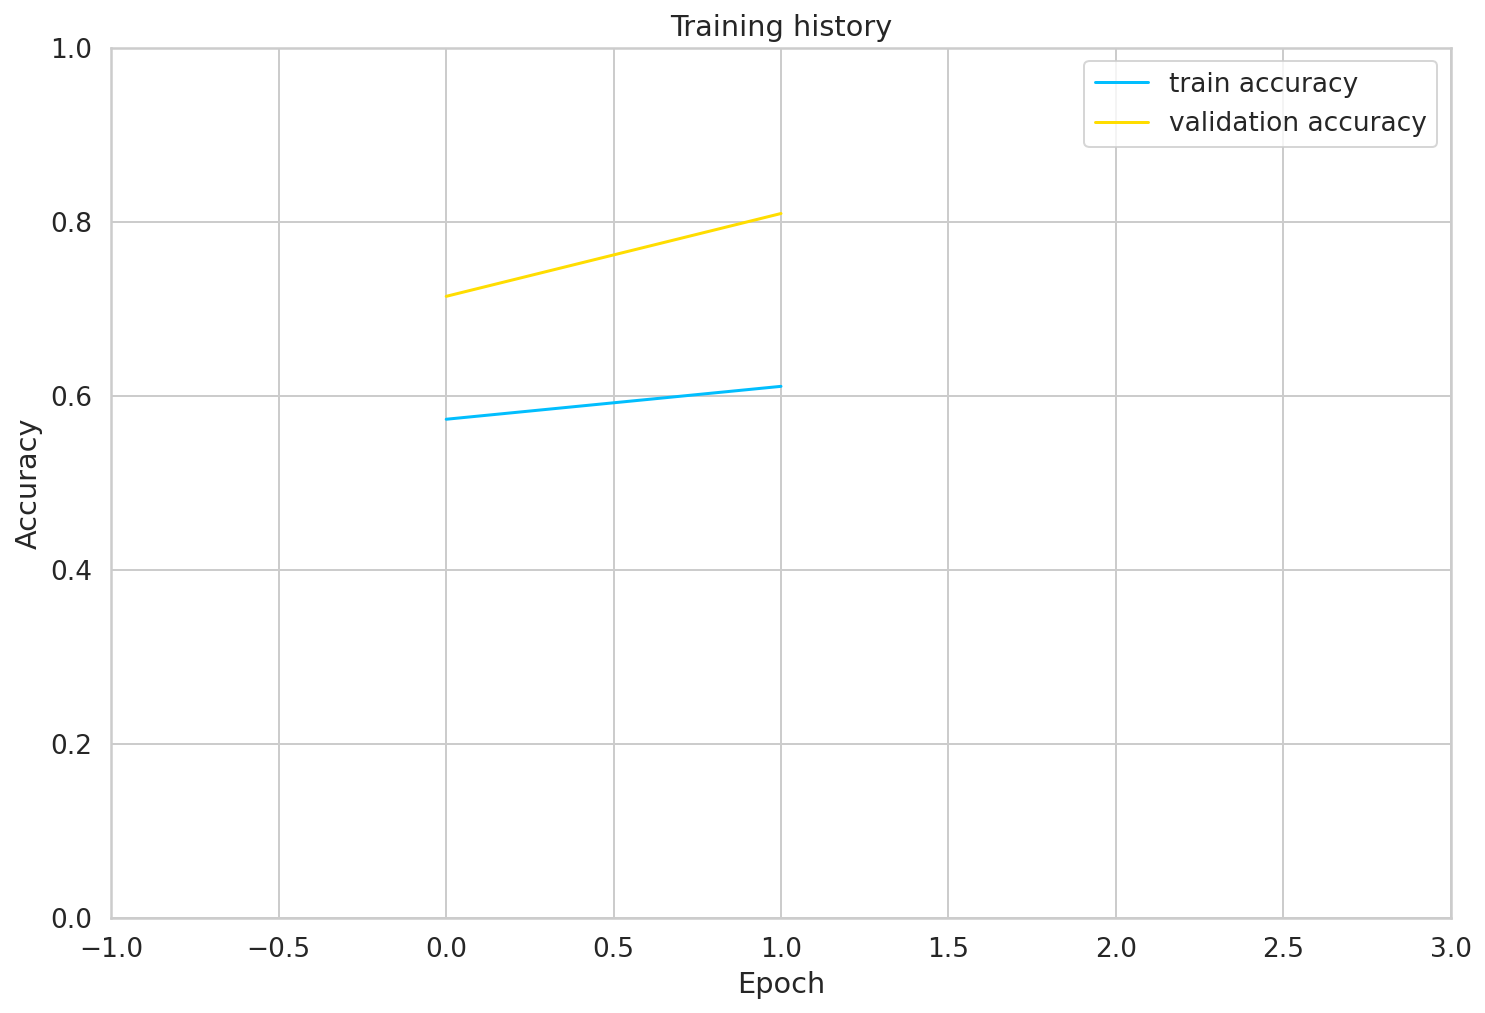

In [197]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.xlim([-1, 3])

## Evaluation


In [202]:
def get_predictions_for_word_support(model, data_loader):
  
  tweets = []
  real_supporting_words = [] 
  real_supporting_vectors = [] 

  predictions_supporting_words = [] 
  predictions_supporting_vectors =[]
  predictions_supporting_probas = []


  with torch.no_grad():

    for b in train_data_loader: 
      tweet = b["review_text"]
      real_supporting_word = b["selected_text"]
      real_supporting_vector = b["target_support_vector"].to(device)
      input_ids = b["input_ids"].to(device)
      attention_mask = b["attention_mask"].to(device)
        
      
      probas_doc,probas_words = model(
      input_ids=input_ids,
      attention_mask=attention_mask)

      probs_word_support_normalized = F.softmax(probas_words, dim=1).reshape(2,70)
      preds_word_support_class1 = probs_word_support_normalized[1] > .5
      prediction_supporting_vector = torch.reshape(preds_word_support_class1,(1,70))
      prediction_supporting_words = tokenizer.batch_decode(input_ids[prediction_supporting_vector == 1])
      prediction_supporting_words= ['--'.join(prediction_supporting_words)]

      tweets.extend(tweet)
      real_supporting_words.extend(real_supporting_word)
      real_supporting_vectors.extend(real_supporting_vector) 
      predictions_supporting_words.extend(prediction_supporting_words)
      predictions_supporting_vectors.extend(prediction_supporting_vector)
      predictions_supporting_probas.extend(probs_word_support_normalized[1])
      

  real_supporting_vectors = torch.stack(real_supporting_vectors).cpu()
  predictions_supporting_vectors = torch.stack(predictions_supporting_vectors).cpu()
  predictions_supporting_probas = torch.stack(predictions_supporting_probas).cpu()
  
  return tweets, real_supporting_words, real_supporting_vectors, predictions_supporting_words, predictions_supporting_probas, predictions_supporting_vectors

In [ ]:
tweets,real_supporting_words,real_supporting_vectors,predictions_supporting_words,predictions_supporting_probas,predictions_supporting_vectors =get_predictions_for_word_support(model,test_data_loader)

### Quantitative evaluation : Jacquard Index

In [206]:
inputs = predictions_supporting_vectors
targets = real_supporting_vectors
smooth = 1

intersection = (inputs * targets).sum()
total = (inputs + targets).sum()
union = total - intersection 
IoU = (intersection + smooth)/(union + smooth)
print("Jacquard Index=",IoU)

Jacquard Index= tensor(0.6740)


### Qualitative evaluation

In [207]:
df_eval = pd.concat([pd.Series(tweets), pd.Series(real_supporting_words), pd.Series(predictions_supporting_words)], axis = 1)
df_eval.columns = ["tweets","real_supporting_words","predictions_supporting_words"]
type(df_eval)
df_eval

,tweets,real_supporting_words,predictions_supporting_words
0,Is also having a lonely night.... Wishing she ...,Is also having a lonely night.... Wishing she ...,I s--a l s o--h a v i n g--a--l o n e l y--n i...
1,watching the original sabrina the teenage witc...,so rad,w a t c h i n g--t h e--o r i g i n a l--s a--...
2,Is also having a lonely night.... Wishing she ...,Is also having a lonely night.... Wishing she ...,I s--a l s o--h a v i n g--a--l o n e l y--n i...
3,HAPPY MOTHERS DAY!,HAPPY MOTHERS DAY!,H--# # A P--# # P--# # Y--M--# # O T--# # H--#...
4,"Wow, such a crazy night of ever changing emoti...",I liked it tho,W o w--I--l i k e d
...,...,...,...
365,"John ohh, I like you. Like, Like-Like you. B...",like,"J o h n--o h--# # h--,--I--l i k e--y o u--.--..."
366,I want to know who is that ??.6 I tried to a...,I want to know who is that ??.6 I tried to as...,I--w a n t--t o--k n o w--w h o--i s--t h a t-...
367,"Its so sunny outside, and I have no one to go ...","Its so sunny outside, and I have no one to go ...","I t s--s o--s u n n y--o u t s i d e--,--a n d..."
368,kate is leaving me all by my lonesome,lonesome,k a--# # t e--i s--l e a v i n g--m e--a l l--...
